# Facemap network for tongue segmentation

#### Import packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from tqdm import tqdm
import random
from scipy import ndimage
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
import utils as img_utils
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from scipy.ndimage import find_objects
from matplotlib import animation
from IPython.display import HTML
from torch.utils.data import ConcatDataset
import pickle, os
import imgaug.augmenters as iaa

## Helper functions

### Network

In [2]:
class FMnet(nn.Module):
    def __init__(
        self,
        img_ch=1,
        output_ch=1,
        channels=[16, 32, 64, 128, 200],
        device=['cuda' if torch.cuda.is_available() else 'cpu'][0],
        kernel=3,
        shape=(256, 256),
        n_upsample=4,
    ):
        super().__init__()
        self.n_upsample = n_upsample
        self.image_shape = shape
        self.device = device

        self.Conv = nn.Sequential()
        self.Conv.add_module(
            "conv0",
            convblock(ch_in=img_ch, ch_out=channels[0], kernel_sz=kernel, block=0),
        )
        for k in range(1, len(channels)):
            self.Conv.add_module(
                f"conv{k}",
                convblock(
                    ch_in=channels[k - 1], ch_out=channels[k], kernel_sz=kernel, block=k
                ),
            )

        self.Up_conv = nn.Sequential()
        for k in range(n_upsample):
            self.Up_conv.add_module(
                f"upconv{k}",
                convblock(
                    ch_in=channels[-1 - k] + channels[-2 - k],
                    ch_out=channels[-2 - k],
                    kernel_sz=kernel,
                ),
            )

        self.Conv2_1x1 = nn.Sequential()
        for j in range(3):
            self.Conv2_1x1.add_module(
                f"conv{j}",
                nn.Conv2d(channels[-2 - k], output_ch, kernel_size=1, padding=0),
            )

    def forward(self, x, normalize=False, verbose=False):
        # encoding path
        xout = []
        x = self.Conv[0](x)
        xout.append(x)
        for k in range(1, len(self.Conv)):
            x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
            x = self.Conv[k](x)
            xout.append(x)

        for k in range(len(self.Up_conv)):
            x = F.interpolate(x, scale_factor=2, mode="nearest")
            x = self.Up_conv[k](torch.cat((x, xout[-2 - k]), axis=1))

        mask = self.Conv2_1x1[0](x)
        mask_edges = self.Conv2_1x1[1](x)
        mask_dist_to_boundary = self.Conv2_1x1[2](x)

        return mask, mask_edges, mask_dist_to_boundary


# Create a gaussian wavelet of a set bin size
def gaussian_wavelet(bin_size, sigma):
    x = np.arange(-bin_size // 2, bin_size // 2 + 1)
    gaussian = np.exp(-(x ** 2) / (2 * sigma ** 2))
    return gaussian / gaussian.sum()


class convblock(nn.Module):
    def __init__(self, ch_in, ch_out, kernel_sz, block=-1):
        super().__init__()
        self.conv = nn.Sequential()
        self.block = block
        if self.block != 0:
            self.conv.add_module("conv_0", batchconv(ch_in, ch_out, kernel_sz))
        else:
            self.conv.add_module("conv_0", batchconv0(ch_in, ch_out, kernel_sz))
        self.conv.add_module("conv_1", batchconv(ch_out, ch_out, kernel_sz))

    def forward(self, x):
        x = self.conv[1](self.conv[0](x))
        return x


def batchconv0(ch_in, ch_out, kernel_sz):
    return nn.Sequential(
        nn.BatchNorm2d(ch_in, eps=1e-5, momentum=0.1),
        nn.Conv2d(ch_in, ch_out, kernel_sz, padding=kernel_sz // 2, bias=False),
    )


def batchconv(ch_in, ch_out, sz):
    return nn.Sequential(
        nn.BatchNorm2d(ch_in, eps=1e-5, momentum=0.1),
        nn.ReLU(inplace=True),
        nn.Conv2d(ch_in, ch_out, sz, padding=sz // 2, bias=False),
    )

### Utils

In [3]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


def iou(pred, target):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (intersection) / (union - intersection)


def get_batch_imgs(video_path, frame_start_idx, grayscale=True, batch_size=1, crop=True, img_size=(144, 192)):
    """
    Parameters
    ----------
    video_path: str
        Path to video file
    frame_start_idx: int
        Index of first frame to extract from video
    crop: bool
        Crop image to remove last 1/3 of the image
    img_size: tuple
        Size for output (final image)
    Returns
    -------
    batch_imgs: 3D-array
        Batch of preprocessed images
    """

    batch_imgs = []

    for i in range(batch_size):
        frame = img_utils.get_frame_from_video(video_path, frame_start_idx+i, grayscale=grayscale)
        frame = normalize99(frame)
        # get cropped image size to remove last 1/3 of the image
        if crop:
            crop_size = (frame.shape[0], int(frame.shape[1] * 2/3-30))
            resized_frame = img_utils.preprocess_img(frame, img_size, crop=crop_size)
        else:
            resized_frame = img_utils.preprocess_img(frame, img_size)
        resized_frame = np.expand_dims(resized_frame, axis=0)
        batch_imgs.append(resized_frame)

    return np.array(batch_imgs)

def predict(net, im_input, sigmoid=True, threshold=0, device=['cuda' if torch.cuda.is_available() else 'cpu'][0]):
    # Predict
    net.eval()
    with torch.no_grad():
        mask_pred, mask_edges_pred, mask_dist_pred = net(im_input.to(device, dtype=torch.float32))
        if sigmoid:
            mask_pred = torch.sigmoid(mask_pred)
            mask_edges_pred = torch.sigmoid(mask_edges_pred)
        if threshold > 0:
            mask_pred[mask_pred > threshold] = 1
            mask_edges_pred[mask_edges_pred > threshold] = 1
            mask_pred[mask_pred <= threshold] = 0
            mask_edges_pred[mask_edges_pred <= threshold] = 0

    return mask_pred.cpu().numpy(), mask_edges_pred.cpu().numpy(), mask_dist_pred.cpu().numpy()

def train(
    train_dataloader,
    val_dataloader, 
    net,
    n_epochs,
    LR,
    weight_decay,
    model_weights_path=None,
    ggmax=50,
    img_size=(256, 256),
    threshold=0.5,
    save_file_name='net',
    save_path=None,
    device=['cuda' if torch.cuda.is_available() else 'cpu'][0],
):
    """
    Fine-tuning the model using the pre-trained weights and refined training data provided by the user.
    Parameters
    ----------
    train_dataloader : torch.utils.data.DataLoader
        The dataloader object containing the training data.
    net : torch.nn.Module
        The model to be trained.
    n_epochs : int
        The number of epochs to be trained.
    LR : list
        The learning rate schedule.
    weight_decay : float
        The weight decay for the optimizer.
    model_weights_path : str
        The path to the pre-trained model weights.
    ggmax : float
        The maximum gradient norm for the optimizer.
    save_path : str
        The path to save the trained model weights.
    device : str
        The device to be used for training.
    """

    if model_weights_path is not None:
        net.load_state_dict(torch.load(model_weights_path))

    # Initialize the optimizer
    optimizer = optim.Adam(
        net.parameters(), lr=LR[0], weight_decay=weight_decay
    )
    loss_fn = nn.BCEWithLogitsLoss() 
    dist_loss = nn.MSELoss()

    epoch_train_loss = []
    epoch_val_loss = []
    epoch_train_acc = []
    epoch_val_acc = []
    best_acc = 0

    # Check if the save path exists, then update the best test accuracy
    if os.path.exists(os.path.join(save_path, save_file_name+'_model_best.pth')):
        best_acc = torch.load(os.path.join(save_path, save_file_name+'_model_best.pth'))['best_test_acc']

    for epoch in tqdm(range(n_epochs)):
        for param_group in optimizer.param_groups:
            param_group["lr"] = LR[epoch]
        set_seed(epoch)
        train_loss = 0
        train_acc = []
        n_batches = 0
        gnorm_max = 0

        for train_batch in train_dataloader:
            net.train()
            images = train_batch["image"].to(device, dtype=torch.float32)
            mask = train_batch["mask"].to(device, dtype=torch.float32)
            mask_edges = train_batch["mask_edges"].to(device, dtype=torch.float32)
            mask_dist_to_boundary = train_batch["mask_dist_to_boundary"].to(device, dtype=torch.float32)

            mask_pred, mask_edges_pred, mask_dist_to_boundary_pred = net(images)

            # Compute loss and distance loss only where the mask is 1
            #mask_dist_to_boundary = torch.where(mask==1, mask_dist_to_boundary, torch.zeros_like(mask)*np.nan)
            #mask_dist_to_boundary_pred = torch.where(mask==1, mask_dist_to_boundary_pred, torch.zeros_like(mask)*np.nan)
            loss = loss_fn(mask_pred, mask) + loss_fn(mask_edges_pred, mask_edges) + 0.1*dist_loss(mask_dist_to_boundary_pred*mask, mask_dist_to_boundary*mask)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()

            # this operation clips the gradient and returns its original norm
            #gnorm = torch.nn.utils.clip_grad_norm_(net.parameters(), ggmax)
            # keep track of the largest gradient norm on this epoch
            #gnorm_max = np.maximum(gnorm_max, gnorm.cpu())

            optimizer.step()

            mask_pred[mask_pred > threshold] = 1
            mask_pred[mask_pred <= threshold] = 0
            train_acc.append(iou(mask_pred.detach().cpu().numpy(), mask.cpu().numpy()).item())

            n_batches += 1

        train_loss /= n_batches
        train_acc = np.nanmean(train_acc) 

        net.eval()
        test_loss = 0
        n_batches = 0
        test_acc = [] 
        
        for val_batch in val_dataloader:
            images = val_batch["image"].to(device, dtype=torch.float32)
            mask = val_batch["mask"].to(device, dtype=torch.float32)
            mask_edges = val_batch["mask_edges"].to(device, dtype=torch.float32)
            mask_dist_to_boundary = val_batch["mask_dist_to_boundary"].to(device, dtype=torch.float32)

            mask_pred, mask_edges_pred, mask_dist_to_boundary_pred = net(images)

            # Compute loss and distance loss only where the mask is 1 (tongue region)
            #mask_dist_to_boundary = torch.where(mask==1, mask_dist_to_boundary, torch.zeros_like(mask)*np.nan)
            #mask_dist_to_boundary_pred = torch.where(mask==1, mask_dist_to_boundary_pred, torch.zeros_like(mask)*np.nan)
            loss = loss_fn(mask_pred, mask) + loss_fn(mask_edges_pred, mask_edges) + 0.1*dist_loss(mask_dist_to_boundary_pred*mask, mask_dist_to_boundary*mask)
            test_loss += loss.item()

            mask_pred[mask_pred > threshold] = 1
            mask_pred[mask_pred <= threshold] = 0
            test_acc.append(iou(mask_pred.detach().cpu().numpy(), mask.cpu().numpy()).item())
            n_batches += 1

        test_loss /= n_batches
        test_acc = np.nanmean(test_acc)

        print(
            "Epoch %d: train loss %f, test loss %f, train acc %f, test acc %f"
            % (epoch, train_loss, test_loss, train_acc, test_acc)
        )
        epoch_train_loss.append(train_loss)
        epoch_val_loss.append(test_loss)
        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(test_acc)

        # Save the model weights if the test loss is the lowest so far
        if save_path is not None and test_acc > best_acc:
            best_acc = test_acc
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': net.state_dict(),
                'best_test_acc': test_acc,
                'optimizer' : optimizer.state_dict(),
                'train_loss': train_loss,
                'test_loss': test_loss,
                'train_acc': train_acc,
                'test_acc': test_acc,
                'lr_scheduler': LR[:epoch],
                'weight_decay': weight_decay,
                }, save_file_name, save_path)
            print("Saved checkpoint at epoch {} with test acc {} to {}".format(epoch, test_acc, os.path.join(save_path, save_file_name+'_model_best.pth')))

    return net, epoch_train_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc

def save_checkpoint(state, save_file, save_path):
    save_file = save_file + '_model_best.pth'
    file_dest = os.path.join(save_path, save_file)
    torch.save(state, file_dest)

def pad_img_to_square(img, bbox=None):
    """
    Pad image to square.
    Parameters
    ----------
    im : ND-array
        image of size [c x h x w]
    bbox: tuple of size (4,)
        bounding box positions in order x1, x2, y1, y2 used for cropping image
    Returns
    -------
    im : ND-array
        padded image of size [c x h x w]
    (pad_w, pad_h) : tuple of int
        padding values for width and height
    """
    if bbox is not None:  # Check if bbox is square
        x1, x2, y1, y2 = bbox
        dx, dy = x2 - x1, y2 - y1
    else:
        dx, dy = img.shape[-2:]

    if dx == dy:
        return img, (0, 0, 0, 0)

    largest_dim = max(dx, dy)
    if (dx < largest_dim and abs(dx - largest_dim) % 2 != 0) or (
        dy < largest_dim and abs(dy - largest_dim) % 2 != 0
    ):
        largest_dim += 1

    if dx < largest_dim:
        pad_x = abs(dx - largest_dim)
        pad_x_left = pad_x // 2
        pad_x_right = pad_x - pad_x_left
    else:
        pad_x_left = 0
        pad_x_right = 0

    if dy < largest_dim:
        pad_y = abs(dy - largest_dim)
        pad_y_top = pad_y // 2
        pad_y_bottom = pad_y - pad_y_top
    else:
        pad_y_top = 0
        pad_y_bottom = 0

    if img.ndim > 3:
        pads = (pad_y_top, pad_y_bottom, pad_x_left, pad_x_right, 0, 0, 0, 0)
    elif img.ndim == 3:
        pads = (pad_y_top, pad_y_bottom, pad_x_left, pad_x_right, 0, 0)
    else:
        pads = (pad_y_top, pad_y_bottom, pad_x_left, pad_x_right)

    img = F.pad(
        img,
        pads,
        mode="constant",
        value=0,
    )

    return img, (pad_y_top, pad_y_bottom, pad_x_left, pad_x_right)


def crop_image(im, bbox=None):
    """
    Crop image to bounding box.
    Parameters
    ----------
    im : ND-array
        image of size [(Lz) x Ly x Lx]
    bbox : tuple of size (4,)
        bounding box positions in order x1, x2, y1, y2
    Returns
    -------
    im : ND-array
        cropped image of size [1 x Ly x Lx]
    """
    if bbox is None:
        return im
    y1, y2, x1, x2 = bbox
    if im.ndim == 2:
        im = im[y1:y2, x1:x2]
    elif im.ndim == 3:
        im = im[:, y1:y2, x1:x2]
    elif im.ndim == 4:
        im = im[:, :, y1:y2, x1:x2]
    else:
        raise ValueError("Cannot handle image with ndim=" + str(im.ndim))
    return im


def resize_image(im, resize_shape):
    """
    Resize image to given height and width.
    Parameters
    ----------
    im : ND-array
        image of size [Ly x Lx]
    resize_shape : tuple of size (2,)
        desired shape of image
    Returns
    -------
    im : ND-array
        resized image of size [h x w]
    """
    h, w = resize_shape
    if im.ndim == 3:
        im = torch.unsqueeze(im, dim=0)
    elif im.ndim == 2:
        im = torch.unsqueeze(im, dim=0)
        im = torch.unsqueeze(im, dim=0)
    im = F.interpolate(im, size=(h, w), mode="bilinear", align_corners=True).squeeze(dim=0)
    return im


def augment_data(
    image,
    mask,
    mask_dist_to_boundary,
    rotate=True,
    rotate_range=5,
    scale=False,
    scale_range=0.5,
    flip=True,
    contrast_adjust=True,
    blur=True,
):
    """
    Augments data by randomly scaling, rotating, flipping, and adjusting contrast
    Parameters
    ----------
    image: ND-array
        image of size nchan x Ly x Lx
    mask: ND-array
        mask of size nchan x Ly x Lx
    mask_edges: ND-array
        mask of size nchan x Ly x Lx
    scale: bool
        whether to scale the image
    scale_range: float
        range of scaling factor
    flip: bool
        whether to flip the image horizontally
    contrast_adjust: bool
        whether to adjust contrast of image
    Returns
    -------
    image: ND-array
        image of size nchan x Ly x Lx
    mask: ND-array
        mask of size nchan x Ly x Lx
    mask_dist_to_boundary: ND-array
        mask of size nchan x Ly x Lx
    """
    if scale and np.random.rand() > 0.5:
        scale_range = max(0, min(2, float(scale_range)))
        scale_factor = (np.random.rand() - 0.5) * scale_range + 1
        image = image.squeeze() * scale_factor
        mask = mask.squeeze() * scale_factor
        mask_dist_to_boundary = mask_dist_to_boundary.squeeze() * scale_factor
    if rotate and np.random.rand() > 0.5:
        theta = np.random.rand() * rotate_range - rotate_range / 2
        image = ndimage.rotate(image, theta, axes=(-2, -1), reshape=False)
        mask = ndimage.rotate(mask, theta, axes=(-2, -1), reshape=False)
        mask_dist_to_boundary = ndimage.rotate(mask_dist_to_boundary, theta, axes=(-2, -1), reshape=False)
    if flip and np.random.rand() > 0.5:
        image = ndimage.rotate(image, 180, axes=(-1, 0), reshape=False)
        mask = ndimage.rotate(mask, 180, axes=(-1, 0), reshape=False)
        mask_dist_to_boundary = ndimage.rotate(mask_dist_to_boundary, 180, axes=(-1, 0), reshape=False)
    if contrast_adjust and np.random.rand() > 0.5:
        image = randomly_adjust_contrast(image)
    if blur and np.random.rand() > 0.5:
        image = blur_image(image, type=["gaussian"]) #, "motion"])

    return image, mask, mask_dist_to_boundary


def blur_image(img, type):
    """
    Blurs image using motion or gaussian blur
    img: ND-array of size nchan x Ly x Lx
    type: list of strings
        type of blur to apply
    """
    if "motion" in type: # Use imgaug package to apply motion blur
        seq = iaa.Sequential([iaa.MotionBlur(k=3, angle=[-45, 45])])
        img = seq(img)
    if "gaussian" in type: # Use scipy.ndimage to apply gaussian blur
        # select a random sigma
        sigma = np.random.rand() * random.randint(0, 5)
        img = ndimage.gaussian_filter(img, sigma=sigma, order=0)
    return img

def randomly_adjust_contrast(img):
    """
    Randomly adjusts contrast of image
    img: ND-array of size nchan x Ly x Lx
    Assumes image values in range 0 to 1
    """
    brange = [-0.2, 0.2]
    bdiff = brange[1] - brange[0]
    crange = [0.7, 1.3]
    cdiff = crange[1] - crange[0]
    imax = img.max()
    if (bdiff < 0.01) and (cdiff < 0.01):
        return img
    bfactor = np.random.rand() * bdiff + brange[0]
    cfactor = np.random.rand() * cdiff + crange[0]
    mm = img.mean()
    jj = img + bfactor * imax
    jj = np.minimum(imax, (jj - mm) * cfactor + mm)
    jj = jj.clip(0, imax)
    return jj


#  Following Function adopted from cellpose:
#  https://github.com/MouseLand/cellpose/blob/35c16c94e285a4ec2fa17f148f06bbd414deb5b8/cellpose/transforms.py#L187
def normalize99(X, device=None):
    """
    Normalize image so 0.0 is 1st percentile and 1.0 is 99th percentile
     Parameters
    -------------
    img: ND-array
        image of size [Ly x Lx]
    Returns
    --------------
    X: ND-array
        normalized image of size [Ly x Lx]
    """
    if device is not None:
        x01 = torch.quantile(X, 0.01)
        x99 = torch.quantile(X, 0.99)
        X = (X - x01) / (x99 - x01)
    else:
        x01 = np.nanpercentile(X, 1)
        x99 = np.nanpercentile(X, 99)
        X = (X - x01) / (x99 - x01)
    return X


### Dataset loader

In [4]:
class TongueMaskDataset(Dataset):
    """Tongue masks dataset."""

    def __init__(self, img, mask=None, mask_dist_to_boundary=None, bbox=None, threshold=4.0, img_size=(256, 256), train=True):
        """
        Args:
            img (ND-array): Image data.
            mask (ND-array): Mask data.
            bbox (ND-array): Bounding box data of the form [[x1, x2, y1, y2]].
            img_size (tuple): Size of the image to be returned.
            train (bool): Whether the dataset is for training or testing.
        """
        self.img = img
        self.mask = mask
        self.bbox = bbox
        self.threshold = threshold
        self.mask_dist_to_boundary = mask_dist_to_boundary #masks_to_edges(self.mask)
        self.train = train
        self.img_size = img_size
        self.img = self.preprocess_imgs(self.img, bbox=self.bbox)
        self.mask = self.preprocess_mask(self.mask, bbox=self.bbox, dtype=np.uint8)
        self.mask_dist_to_boundary = np.array(self.preprocess_mask(self.mask_dist_to_boundary, bbox=self.bbox, dtype=np.float32, interpolation='bilinear'))
        self.mask_dist_to_boundary = np.squeeze(self.mask_dist_to_boundary, axis=1)
        
    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        img = self.img[idx]
        mask = self.mask[idx]
        mask_dist_to_boundary = self.mask_dist_to_boundary[idx]

        if self.train:
            img, mask, mask_dist_to_boundary = augment_data(img, mask, mask_dist_to_boundary)

        # Get edges from the distance to boundary mask
        mask_edges = (mask_dist_to_boundary < self.threshold) * (mask > 0)
        
        # If not a tensor, convert to tensor
        if not isinstance(img, torch.Tensor):
            img = torch.from_numpy(img)
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).to(torch.float)
        if not isinstance(mask_edges, torch.Tensor):
            mask_edges = torch.from_numpy(mask_edges)
        if not isinstance(mask_dist_to_boundary, torch.Tensor):
            mask_dist_to_boundary = torch.from_numpy(mask_dist_to_boundary)

        sample = {'image': img, 'mask': mask,  'mask_edges': mask_edges, 'mask_dist_to_boundary': mask_dist_to_boundary, 'idx': idx}

        return sample

    def preprocess_mask(self, mask_data, bbox, dtype=None, interpolation='nearest'):
        """
        Parameters
        ----------
        mask_data : list of ND-array of shape (C, W, H)
            List of masks.
        Returns
        -------
        mask_data : list of ND-array of shape (C, W, H)
            List of masks.
        """
        masks = []
        for m in mask_data:
            if dtype is not None:
                m = m.astype(dtype)
            m = torch.from_numpy(m)#.type(torch.float)   # convert to uint8
            # 1. Crop mask
            m = crop_image(m, bbox)
            m, _ = pad_img_to_square(m) 
            if interpolation == 'bilinear':
                m = resize_image(m, self.img_size)
            elif interpolation == 'nearest':
                m = SegmentationMapsOnImage(m.numpy(), shape=self.img_size)
                m = m.resize(self.img_size, interpolation="nearest").get_arr()
            else:
                raise ValueError('Interpolation method not supported.')
            m = np.expand_dims(m, axis=0)
            masks.append(m)
        return masks

    def preprocess_imgs(self, image_data, bbox):
        """
        Preprocess images to be in the range [0, 1] and normalize99
        Parameters
        ----------
        image_data : list of ND-array of shape (C, W, H)
            List of images.
        Returns
        -------
        image_data : list of ND-array of shape (C, W, H)
            List of images.
        """
        imgs = []
        for im in image_data:
            im = torch.from_numpy(im)
            # Normalize
            im = normalize99(im)
            # 1. Crop image
            im = crop_image(im, bbox)
             # 2. Pad image to square
            im, _ = pad_img_to_square(im)
            # 3. Resize image to resize_shape for model input
            im = resize_image(im, self.img_size)
            imgs.append(im)
        return imgs

    def preprocess_data(self, image, mask, mask_edges, bbox):
        """
        Preproccesing of image involves:
            1. Cropping image to select bounding box (bbox) region
            2. Padding image size to be square
            3. Resize image to Lx x Ly for model input
        Parameters
        -------------
        image: ND-array
            image of size [(Lz) x Ly x Lx]
        mask: ND-array
            mask of size [(Lz) x Ly x Lx]
        mask_edges: ND-array
            mask outline/edges of size [(Lz) x Ly x Lx]
        mask_dist_to_boundary: ND-array
            distance to boundary of size [(Lz) x Ly x Lx]
        bbox: tuple of size (4,)
            bounding box positions in order x1, x2, y1, y2
        Returns
        --------------
        image: ND-array
            preprocessed image of size [1 x Ly x Lx]
        mask: ND-array
            preprocessed mask of size [1 x Ly x Lx]
        """
        # 1. Crop image
        image = crop_image(image, bbox)
        mask = crop_image(mask, bbox)
        mask_edges = crop_image(mask_edges, bbox)
        y1, _, x1, _ = bbox
        
        # 2. Pad image to square
        image, (pad_y_top, pad_y_bottom, pad_x_left, pad_x_right) = pad_img_to_square(image)
        mask, _ = pad_img_to_square(mask) 
        mask_edges, _ = pad_img_to_square(mask_edges)

        # 3. Resize image to resize_shape for model input
        image = resize_image(image, self.img_size)
        mask = SegmentationMapsOnImage(mask.numpy(), shape=image.shape)
        mask = mask.resize(self.img_size, interpolation="nearest").get_arr()
        mask = np.expand_dims(mask, axis=0)
        mask_edges = SegmentationMapsOnImage(mask_edges.numpy(), shape=image.shape)
        mask_edges = mask_edges.resize(self.img_size, interpolation="nearest").get_arr()
        mask_edges = np.expand_dims(mask_edges, axis=0)

        return image, mask, mask_edges

def load_data(dat_filepath, image_field_name='assembledRandomizedClips_bottom', mask_field_name='mask_stack_bottom', rotate=True):
    """
        Args:
            dat_filepath (string): Path to the mat file with annotations.
            image_field_name (string): Name of the field in the mat file that contains the image data.
            mask_field_name (string): Name of the field in the mat file that contains the mask data.
        Returns:
            img: ND-array of size nchan x Ly x Lx
            mask: ND-array of size nchan x Ly x Lx
    """
    # check file extension
    _, ext = os.path.splitext(dat_filepath)
    if ext == '.mat':
        data = loadmat(dat_filepath)
    elif ext == '.pkl':
        with open(dat_filepath, 'rb') as f:
            data = pickle.load(f)
    else:
        raise ValueError('File extension not supported: {}'.format(ext))
    img = data[image_field_name] 
    mask = data[mask_field_name]
    mask_distance_to_boundary = data['mask_distance_to_boundary']
    if rotate:
        # rotate image and mask 90 degrees
        img = np.rot90(img, 1, (1, 2)).copy()
        mask = np.rot90(mask, 1, (1, 2)).copy()
        mask_distance_to_boundary = np.rot90(mask_distance_to_boundary, 1, (1, 2)).copy()
    return img, mask, mask_distance_to_boundary

### Load data and visualize

In [5]:
IMG_SIZE = (256, 256)
model_name = 'facemapNet_bottom_distmasked' #'facemapNet_bottom_distmasked' #  'facemapNet_side'

In [6]:
if "bottom" in model_name:
    dataset_files = ['/home/asyeda/Hopkins/Jupyter_notebooks/segmentation_pytorch/datasets/goldberg_bottom_dataset.mat', 
                    '/home/asyeda/Hopkins/Jupyter_notebooks/segmentation_pytorch/datasets/oconnorlab_bottom_train_dataset.pkl']
elif "side" in model_name:
    dataset_files = ['/home/asyeda/Hopkins/Jupyter_notebooks/segmentation_pytorch/datasets/goldberg_side_dataset.mat']
else:
    raise ValueError("Model name not recognized: {}".format(model_name))
dataset = []
for dataset_file in dataset_files:
    if 'goldberg' in dataset_file and 'bottom' in dataset_file:
        rotate = True   
    else:
        rotate = False
    imgs, masks, mask_dist_to_boundary = load_data(dataset_file, image_field_name='imgs', mask_field_name='masks', rotate=rotate)
    bbox = [0, imgs.shape[1], 0, imgs.shape[2]] # Bounding box for the frames [x1, x2, y1, y2]
    dat = TongueMaskDataset(imgs, masks, mask_dist_to_boundary, bbox=bbox, img_size=IMG_SIZE, train=True)
    dataset.append(dat)
train_dataset = ConcatDataset(dataset)

In [7]:
val_split = 0.05
train_size, val_size = int(len(train_dataset)-np.ceil(len(train_dataset)*val_split)), int(np.ceil(len(train_dataset)*val_split))
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size],
                                                    torch.Generator().manual_seed(42))
train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=8, shuffle=True,
                                            num_workers=8)
val_loader = torch.utils.data.DataLoader(val_data,
                                        batch_size=4, shuffle=True,
                                        num_workers=8)

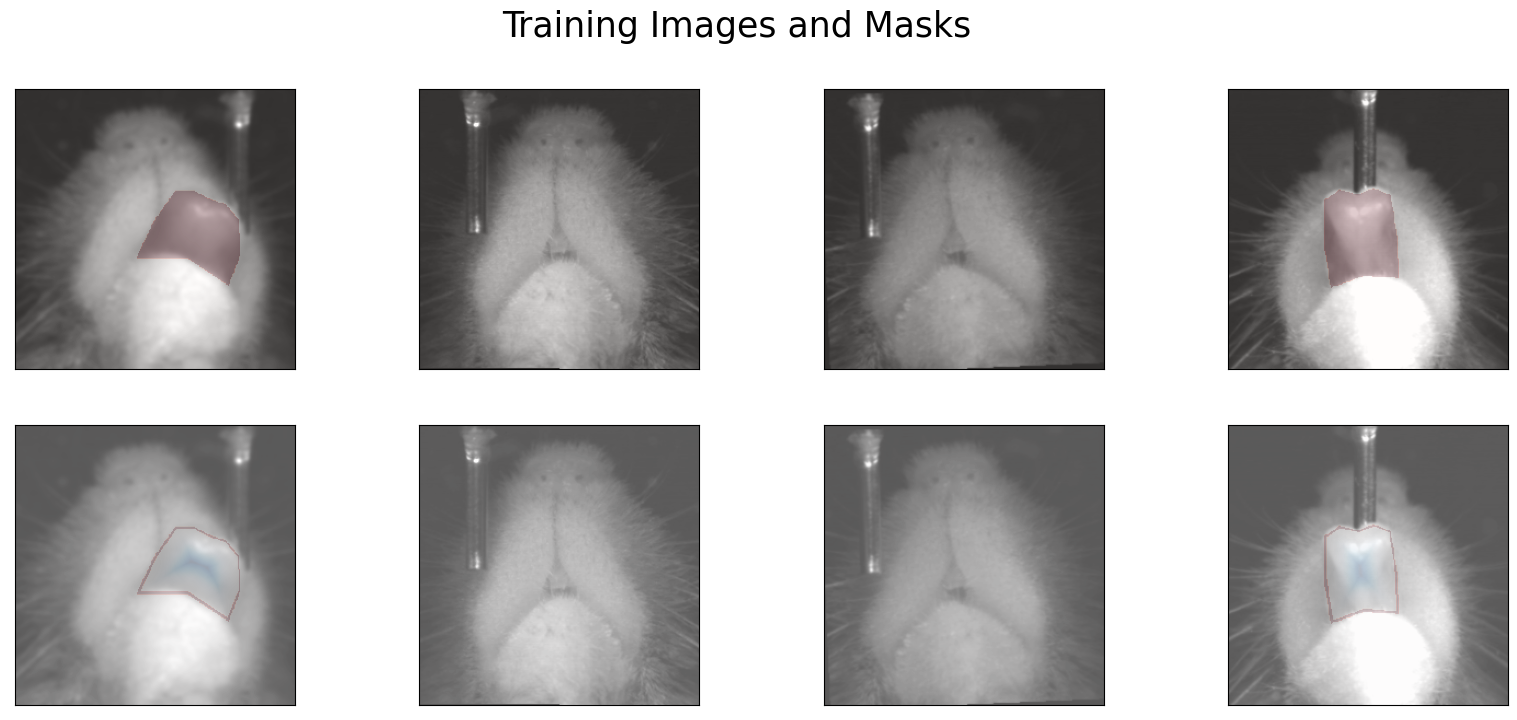

Text(0.5, 0.98, 'Validation Images and Masks')

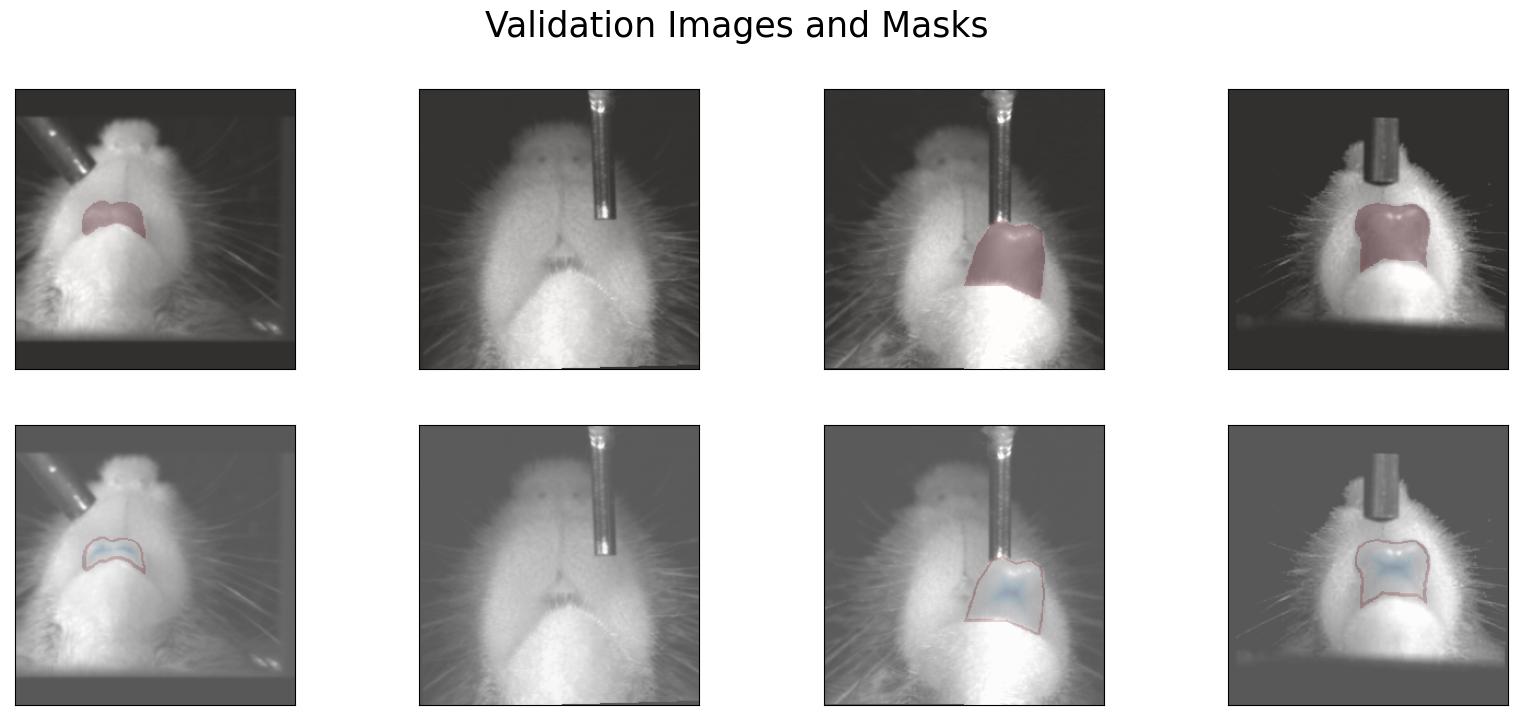

In [8]:
# Get a batch of training data
batch_data = next(iter(train_loader))
inputs, masks, mask_edges, mask_dist_to_boundary = batch_data['image'], batch_data['mask'], batch_data['mask_edges'], batch_data['mask_dist_to_boundary']
# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 8))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(inputs[idx].numpy().squeeze(), cmap='gray')
    plt.imshow(masks[idx].numpy().squeeze(), alpha=0.2, cmap='Reds')
    ax = fig.add_subplot(2, 4, idx+5, xticks=[], yticks=[])
    plt.imshow(inputs[idx].numpy().squeeze(), cmap='gray')
    plt.imshow(mask_edges[idx].cpu().numpy().squeeze(), cmap='Reds', alpha=0.2)
    plt.imshow(mask_dist_to_boundary[idx].cpu().numpy().squeeze(), cmap='Blues', alpha=0.2)
fig.suptitle('Training Images and Masks', fontsize=25)
plt.show()

# Get a batch of validation data
batch_data = next(iter(val_loader))
inputs, masks, mask_edges, mask_dist_to_boundary = batch_data['image'], batch_data['mask'], batch_data['mask_edges'], batch_data['mask_dist_to_boundary']
# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 8))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(inputs[idx].numpy().squeeze(), cmap='gray')
    plt.imshow(masks[idx].numpy().squeeze(), alpha=0.2, cmap='Reds')
    ax = fig.add_subplot(2, 4, idx+5, xticks=[], yticks=[])
    plt.imshow(inputs[idx].numpy().squeeze()*1, cmap='gray')
    plt.imshow(mask_edges[idx].cpu().numpy().squeeze(), cmap='Reds', alpha=0.2)
    plt.imshow(mask_dist_to_boundary[idx].cpu().numpy().squeeze(), cmap='Blues', alpha=0.2)
fig.suptitle('Validation Images and Masks', fontsize=25)

In [9]:
print('Number of unique values in mask:', len(torch.unique(masks)), torch.unique(masks))
print('Number of unique values in mask edges:', len(torch.unique(mask_edges)), torch.unique(mask_edges))

Number of unique values in mask: 2 tensor([0., 1.])
Number of unique values in mask edges: 2 tensor([False,  True])


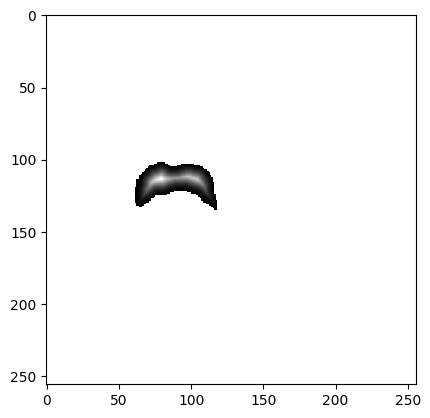

In [10]:
plt.imshow(torch.where(masks==1, mask_dist_to_boundary, torch.zeros_like(masks)*np.nan)[0,0], cmap='gray')

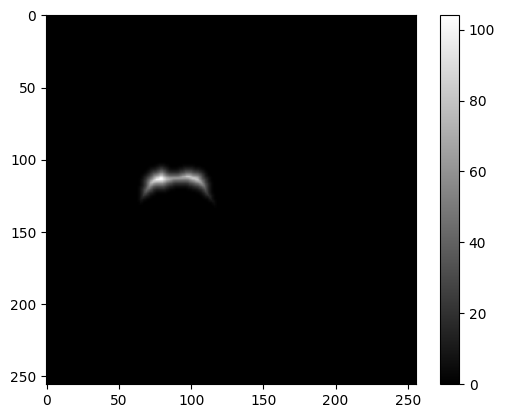

In [11]:
plt.imshow((mask_dist_to_boundary*masks)[0,0], cmap='gray')
plt.colorbar()

## Train model

In [12]:
## Initialize the model
device = ['cuda' if torch.cuda.is_available() else 'cpu'][0]
net = FMnet().to(device)

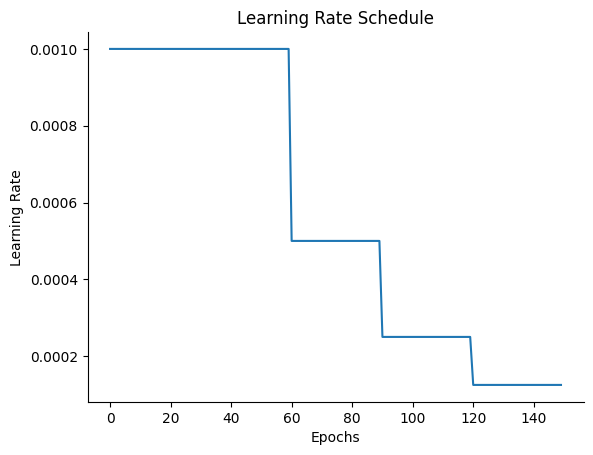

In [14]:
learning_rate = 1e-3
n_epochs = 150
change_lr_every = 30
change_lr_epoch = 60
if n_epochs > change_lr_epoch:
    LR = np.ones(change_lr_epoch)*learning_rate
    for i in range(int(np.ceil((n_epochs-change_lr_epoch)/change_lr_every))):
        LR = np.append(LR, LR[-1]/2 * np.ones(change_lr_every))
else:
    LR = np.ones(n_epochs)*learning_rate
    LR[-6:-3] = LR[-1]/10
    LR[-3:] = LR[-1]/25
# Plot the learning rate schedule
plt.plot(LR)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
# hide the spines between ax and ax2
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

In [15]:
net, epoch_train_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc = train(train_loader, val_loader, net,
                                                                             n_epochs=n_epochs, LR=LR, weight_decay=1e-3, img_size=IMG_SIZE,
                                                                             save_file_name=model_name, 
                                                                             save_path='/home/asyeda/Hopkins/Jupyter_notebooks/segmentation_pytorch/model_weights')

  0%|          | 0/150 [00:00<?, ?it/s]/tmp/ipykernel_415327/903541701.py:13: RuntimeWarning: invalid value encountered in scalar divide
  return (intersection) / (union - intersection)
  1%|          | 1/150 [02:13<5:31:29, 133.49s/it]

Epoch 0: train loss 54.516206, test loss 24.407610, train acc 0.013750, test acc 0.043275


  1%|▏         | 2/150 [04:31<5:35:58, 136.21s/it]

Epoch 1: train loss 17.915752, test loss 13.576236, train acc 0.019700, test acc 0.014746


  2%|▏         | 3/150 [06:50<5:37:14, 137.65s/it]

Epoch 2: train loss 11.756489, test loss 13.166649, train acc 0.033601, test acc 0.024766


  3%|▎         | 4/150 [09:10<5:37:10, 138.56s/it]

Epoch 3: train loss 9.977228, test loss 30.288455, train acc 0.044272, test acc 0.012689


  3%|▎         | 5/150 [11:31<5:36:12, 139.12s/it]

Epoch 4: train loss 8.489287, test loss 12.588693, train acc 0.097247, test acc 0.066541


  4%|▍         | 6/150 [13:51<5:34:48, 139.51s/it]

Epoch 5: train loss 7.550087, test loss 6.981948, train acc 0.151272, test acc 0.074501


  5%|▍         | 7/150 [16:10<5:32:28, 139.50s/it]

Epoch 6: train loss 7.733776, test loss 11.111118, train acc 0.161249, test acc 0.049595


  5%|▌         | 8/150 [18:30<5:30:16, 139.56s/it]

Epoch 7: train loss 6.161487, test loss 6.499149, train acc 0.242640, test acc 0.287563


  6%|▌         | 9/150 [20:52<5:29:47, 140.34s/it]

Epoch 8: train loss 5.895429, test loss 7.961972, train acc 0.306306, test acc 0.262885


  7%|▋         | 10/150 [23:13<5:27:46, 140.47s/it]

Epoch 9: train loss 5.806313, test loss 8.022270, train acc 0.334686, test acc 0.209974


  7%|▋         | 11/150 [25:33<5:24:53, 140.24s/it]

Epoch 10: train loss 5.175583, test loss 5.901663, train acc 0.382579, test acc 0.359293


  8%|▊         | 12/150 [27:53<5:22:55, 140.40s/it]

Epoch 11: train loss 5.739356, test loss 6.438883, train acc 0.390128, test acc 0.336604


  9%|▊         | 13/150 [30:14<5:20:42, 140.46s/it]

Epoch 12: train loss 4.843137, test loss 5.518339, train acc 0.453809, test acc 0.368817


  9%|▉         | 14/150 [32:35<5:18:32, 140.53s/it]

Epoch 13: train loss 5.137568, test loss 6.348226, train acc 0.470094, test acc 0.367479


 10%|█         | 15/150 [34:56<5:16:43, 140.77s/it]

Epoch 14: train loss 4.546315, test loss 4.486441, train acc 0.516479, test acc 0.428828


 11%|█         | 16/150 [37:17<5:14:20, 140.75s/it]

Epoch 15: train loss 4.309847, test loss 4.403431, train acc 0.540302, test acc 0.392572


 11%|█▏        | 17/150 [39:37<5:11:30, 140.53s/it]

Epoch 16: train loss 4.600066, test loss 4.760840, train acc 0.545615, test acc 0.573275


 12%|█▏        | 18/150 [41:58<5:09:30, 140.68s/it]

Epoch 17: train loss 4.342670, test loss 7.229484, train acc 0.559327, test acc 0.312704


 13%|█▎        | 19/150 [44:19<5:07:35, 140.88s/it]

Epoch 18: train loss 4.028124, test loss 4.406234, train acc 0.567645, test acc 0.550735


 13%|█▎        | 20/150 [46:40<5:05:22, 140.94s/it]

Epoch 19: train loss 4.261942, test loss 4.220147, train acc 0.568738, test acc 0.448416


 14%|█▍        | 21/150 [49:01<5:03:02, 140.95s/it]

Epoch 20: train loss 4.915244, test loss 4.051088, train acc 0.509720, test acc 0.554082


 15%|█▍        | 22/150 [51:20<4:59:43, 140.50s/it]

Epoch 21: train loss 3.823806, test loss 3.786045, train acc 0.583157, test acc 0.560318


 15%|█▌        | 23/150 [53:41<4:57:36, 140.61s/it]

Epoch 22: train loss 3.725316, test loss 4.536520, train acc 0.621188, test acc 0.516271


 16%|█▌        | 24/150 [56:03<4:56:00, 140.95s/it]

Epoch 23: train loss 4.460728, test loss 4.039357, train acc 0.565664, test acc 0.483343


 17%|█▋        | 25/150 [58:24<4:53:42, 140.98s/it]

Epoch 24: train loss 4.020532, test loss 4.748507, train acc 0.615337, test acc 0.486195


 17%|█▋        | 26/150 [1:00:44<4:50:39, 140.64s/it]

Epoch 25: train loss 4.152808, test loss 3.848420, train acc 0.562967, test acc 0.546380


 18%|█▊        | 27/150 [1:03:05<4:48:37, 140.80s/it]

Epoch 26: train loss 3.564164, test loss 3.745308, train acc 0.628380, test acc 0.522531


 19%|█▊        | 28/150 [1:05:27<4:46:58, 141.14s/it]

Epoch 27: train loss 3.665773, test loss 3.696812, train acc 0.649936, test acc 0.559965


 19%|█▉        | 29/150 [1:07:48<4:44:40, 141.16s/it]

Epoch 28: train loss 3.535630, test loss 4.084324, train acc 0.642093, test acc 0.524346


 20%|██        | 30/150 [1:10:10<4:42:39, 141.33s/it]

Epoch 29: train loss 3.721207, test loss 3.873024, train acc 0.639009, test acc 0.515498


 21%|██        | 31/150 [1:12:31<4:40:03, 141.21s/it]

Epoch 30: train loss 3.417961, test loss 3.957464, train acc 0.659857, test acc 0.509561


 21%|██▏       | 32/150 [1:14:50<4:36:18, 140.50s/it]

Epoch 31: train loss 3.469821, test loss 4.768686, train acc 0.662074, test acc 0.506957


 22%|██▏       | 33/150 [1:17:12<4:35:09, 141.11s/it]

Epoch 32: train loss 3.424586, test loss 4.505854, train acc 0.646942, test acc 0.515164


 23%|██▎       | 34/150 [1:19:33<4:32:42, 141.06s/it]

Epoch 33: train loss 3.324298, test loss 4.054607, train acc 0.672134, test acc 0.540736


 23%|██▎       | 35/150 [1:21:54<4:30:23, 141.07s/it]

Epoch 34: train loss 3.479233, test loss 3.653872, train acc 0.656540, test acc 0.543007


 24%|██▍       | 36/150 [1:24:15<4:27:43, 140.90s/it]

Epoch 35: train loss 3.727747, test loss 3.232204, train acc 0.635072, test acc 0.576405


 25%|██▍       | 37/150 [1:26:37<4:25:59, 141.23s/it]

Epoch 36: train loss 3.100612, test loss 4.057307, train acc 0.693341, test acc 0.526587


 25%|██▌       | 38/150 [1:28:58<4:23:39, 141.25s/it]

Epoch 37: train loss 3.246090, test loss 3.874453, train acc 0.674031, test acc 0.616104


 26%|██▌       | 39/150 [1:31:19<4:21:17, 141.24s/it]

Epoch 38: train loss 3.192679, test loss 5.258455, train acc 0.688276, test acc 0.282554


 27%|██▋       | 40/150 [1:33:40<4:18:35, 141.05s/it]

Epoch 39: train loss 3.465199, test loss 3.440845, train acc 0.651971, test acc 0.622266


 27%|██▋       | 41/150 [1:36:00<4:15:50, 140.83s/it]

Epoch 40: train loss 3.086213, test loss 3.439152, train acc 0.695643, test acc 0.618050


 28%|██▊       | 42/150 [1:38:21<4:13:22, 140.76s/it]

Epoch 41: train loss 3.209800, test loss 3.599539, train acc 0.687460, test acc 0.584793


 29%|██▊       | 43/150 [1:40:42<4:11:25, 140.99s/it]

Epoch 42: train loss 3.070149, test loss 3.380213, train acc 0.694599, test acc 0.216916


 29%|██▉       | 44/150 [1:43:04<4:09:22, 141.15s/it]

Epoch 43: train loss 3.295324, test loss 4.378331, train acc 0.686046, test acc 0.536295


 30%|███       | 45/150 [1:45:25<4:06:47, 141.02s/it]

Epoch 44: train loss 3.009801, test loss 3.375042, train acc 0.702575, test acc 0.645580


 31%|███       | 46/150 [1:47:45<4:03:51, 140.69s/it]

Epoch 45: train loss 3.640036, test loss 3.842523, train acc 0.652068, test acc 0.527556


 31%|███▏      | 47/150 [1:50:06<4:01:50, 140.88s/it]

Epoch 46: train loss 2.980973, test loss 3.390705, train acc 0.700778, test acc 0.625126


 32%|███▏      | 48/150 [1:52:27<3:59:39, 140.98s/it]

Epoch 47: train loss 3.148989, test loss 3.433783, train acc 0.690628, test acc 0.590339


 33%|███▎      | 49/150 [1:54:48<3:57:27, 141.06s/it]

Epoch 48: train loss 3.034726, test loss 3.262840, train acc 0.701600, test acc 0.586245


 33%|███▎      | 50/150 [1:57:09<3:54:50, 140.90s/it]

Epoch 49: train loss 2.949951, test loss 3.109850, train acc 0.709700, test acc 0.571167


 34%|███▍      | 51/150 [1:59:29<3:52:12, 140.73s/it]

Epoch 50: train loss 2.981315, test loss 4.309103, train acc 0.710495, test acc 0.538019


 35%|███▍      | 52/150 [2:01:51<3:50:21, 141.03s/it]

Epoch 51: train loss 3.023502, test loss 3.224878, train acc 0.723350, test acc 0.646147


 35%|███▌      | 53/150 [2:04:12<3:48:03, 141.07s/it]

Epoch 52: train loss 2.882659, test loss 3.603920, train acc 0.726401, test acc 0.551824


 36%|███▌      | 54/150 [2:06:28<3:43:22, 139.61s/it]

Epoch 53: train loss 2.951792, test loss 3.206037, train acc 0.716451, test acc 0.580635


 37%|███▋      | 55/150 [2:08:47<3:40:30, 139.27s/it]

Epoch 54: train loss 2.923797, test loss 3.694948, train acc 0.727999, test acc 0.578560


 37%|███▋      | 56/150 [2:11:08<3:38:58, 139.77s/it]

Epoch 55: train loss 3.230666, test loss 9.650615, train acc 0.680497, test acc 0.469774


 38%|███▊      | 57/150 [2:13:30<3:37:47, 140.51s/it]

Epoch 56: train loss 2.995114, test loss 3.263489, train acc 0.709610, test acc 0.651641


 39%|███▊      | 58/150 [2:15:49<3:34:36, 139.96s/it]

Epoch 57: train loss 2.959324, test loss 3.218103, train acc 0.719546, test acc 0.632883


 39%|███▉      | 59/150 [2:18:08<3:31:46, 139.63s/it]

Epoch 58: train loss 3.014633, test loss 3.307862, train acc 0.727644, test acc 0.576153


 40%|████      | 60/150 [2:20:22<3:26:53, 137.93s/it]

Epoch 59: train loss 2.948172, test loss 3.612523, train acc 0.729897, test acc 0.608302


 41%|████      | 61/150 [2:22:34<3:22:00, 136.18s/it]

Epoch 60: train loss 2.398986, test loss 2.853224, train acc 0.783348, test acc 0.687490


 41%|████▏     | 62/150 [2:24:46<3:17:57, 134.98s/it]

Epoch 61: train loss 2.253069, test loss 2.750074, train acc 0.793275, test acc 0.715958


 42%|████▏     | 63/150 [2:26:59<3:14:59, 134.48s/it]

Epoch 62: train loss 2.176005, test loss 2.669228, train acc 0.791766, test acc 0.703262


 43%|████▎     | 64/150 [2:29:13<3:12:34, 134.35s/it]

Epoch 63: train loss 2.175513, test loss 2.625233, train acc 0.794091, test acc 0.631043


 43%|████▎     | 65/150 [2:31:27<3:10:05, 134.18s/it]

Epoch 64: train loss 2.171781, test loss 3.219273, train acc 0.800678, test acc 0.701782


 44%|████▍     | 66/150 [2:33:39<3:07:03, 133.61s/it]

Epoch 65: train loss 2.134077, test loss 2.730880, train acc 0.798550, test acc 0.709648


 45%|████▍     | 67/150 [2:35:55<3:05:38, 134.20s/it]

Epoch 66: train loss 2.078000, test loss 2.594972, train acc 0.801821, test acc 0.669352


 45%|████▌     | 68/150 [2:38:13<3:05:10, 135.49s/it]

Epoch 67: train loss 2.109842, test loss 2.475900, train acc 0.801078, test acc 0.690601


 46%|████▌     | 69/150 [2:40:32<3:04:13, 136.47s/it]

Epoch 68: train loss 2.106946, test loss 2.658533, train acc 0.804320, test acc 0.736461


 47%|████▋     | 70/150 [2:42:47<3:01:20, 136.00s/it]

Epoch 69: train loss 2.044430, test loss 2.718431, train acc 0.803428, test acc 0.702421


 47%|████▋     | 71/150 [2:45:08<3:00:53, 137.39s/it]

Epoch 70: train loss 2.086299, test loss 2.746315, train acc 0.805032, test acc 0.685391


 48%|████▊     | 72/150 [2:47:27<2:59:21, 137.97s/it]

Epoch 71: train loss 2.074698, test loss 2.641519, train acc 0.802941, test acc 0.706623


 49%|████▊     | 73/150 [2:49:47<2:58:01, 138.72s/it]

Epoch 72: train loss 1.991013, test loss 2.679432, train acc 0.805866, test acc 0.754612


 49%|████▉     | 74/150 [2:52:10<2:57:09, 139.86s/it]

Epoch 73: train loss 2.052622, test loss 3.234122, train acc 0.806259, test acc 0.673370


 50%|█████     | 75/150 [2:54:38<2:57:52, 142.30s/it]

Epoch 74: train loss 2.063527, test loss 2.788305, train acc 0.802801, test acc 0.706238


 51%|█████     | 76/150 [2:56:50<2:51:34, 139.11s/it]

Epoch 75: train loss 2.005224, test loss 2.703599, train acc 0.808112, test acc 0.724461


 51%|█████▏    | 77/150 [2:59:02<2:46:39, 136.98s/it]

Epoch 76: train loss 2.012063, test loss 3.046227, train acc 0.809029, test acc 0.678571


 52%|█████▏    | 78/150 [3:01:18<2:44:01, 136.69s/it]

Epoch 77: train loss 1.978831, test loss 2.617864, train acc 0.812319, test acc 0.698035


 53%|█████▎    | 79/150 [3:03:48<2:46:27, 140.67s/it]

Epoch 78: train loss 1.986860, test loss 2.710537, train acc 0.811684, test acc 0.717645


 53%|█████▎    | 80/150 [3:06:04<2:42:33, 139.33s/it]

Epoch 79: train loss 1.955006, test loss 2.756414, train acc 0.807222, test acc 0.641751


 54%|█████▍    | 81/150 [3:08:19<2:38:56, 138.21s/it]

Epoch 80: train loss 1.936082, test loss 2.829993, train acc 0.812398, test acc 0.711627


 55%|█████▍    | 82/150 [3:10:37<2:36:34, 138.15s/it]

Epoch 81: train loss 1.909638, test loss 2.935034, train acc 0.810340, test acc 0.694111


 55%|█████▌    | 83/150 [3:13:02<2:36:33, 140.21s/it]

Epoch 82: train loss 1.975394, test loss 2.456748, train acc 0.808708, test acc 0.726806


 56%|█████▌    | 84/150 [3:15:23<2:34:31, 140.48s/it]

Epoch 83: train loss 1.949809, test loss 2.535230, train acc 0.810319, test acc 0.680493


 57%|█████▋    | 85/150 [3:17:45<2:32:39, 140.92s/it]

Epoch 84: train loss 1.993657, test loss 2.890803, train acc 0.810357, test acc 0.642306


 57%|█████▋    | 86/150 [3:20:06<2:30:17, 140.89s/it]

Epoch 85: train loss 1.982001, test loss 2.754231, train acc 0.806442, test acc 0.665733


 58%|█████▊    | 87/150 [3:22:27<2:27:52, 140.84s/it]

Epoch 86: train loss 1.950322, test loss 2.808479, train acc 0.811377, test acc 0.730627


 59%|█████▊    | 88/150 [3:24:49<2:25:52, 141.17s/it]

Epoch 87: train loss 2.003173, test loss 2.851183, train acc 0.803470, test acc 0.687429


 59%|█████▉    | 89/150 [3:27:06<2:22:09, 139.83s/it]

Epoch 88: train loss 1.949438, test loss 2.476753, train acc 0.809292, test acc 0.721572


 60%|██████    | 90/150 [3:29:27<2:20:25, 140.42s/it]

Epoch 89: train loss 1.894412, test loss 2.492373, train acc 0.814212, test acc 0.690180


 61%|██████    | 91/150 [3:31:48<2:18:06, 140.45s/it]

Epoch 90: train loss 1.653469, test loss 2.282559, train acc 0.837834, test acc 0.763766


 61%|██████▏   | 92/150 [3:34:07<2:15:19, 139.99s/it]

Epoch 91: train loss 1.563672, test loss 2.204412, train acc 0.838649, test acc 0.761117


 62%|██████▏   | 93/150 [3:36:25<2:12:20, 139.30s/it]

Epoch 92: train loss 1.593916, test loss 2.415971, train acc 0.835688, test acc 0.784710
Saved checkpoint at epoch 92 with test acc 0.7847100002954235 to /home/asyeda/Hopkins/Jupyter_notebooks/segmentation_pytorch/model_weights/facemapNet_bottom_distmasked_model_best.pth


 63%|██████▎   | 94/150 [3:38:46<2:10:34, 139.90s/it]

Epoch 93: train loss 1.543247, test loss 2.240728, train acc 0.841297, test acc 0.747764


 63%|██████▎   | 95/150 [3:41:07<2:08:34, 140.27s/it]

Epoch 94: train loss 1.526829, test loss 2.149821, train acc 0.843726, test acc 0.775925


 64%|██████▍   | 96/150 [3:43:27<2:06:15, 140.29s/it]

Epoch 95: train loss 1.499808, test loss 2.344423, train acc 0.841675, test acc 0.781665


 65%|██████▍   | 97/150 [3:45:50<2:04:35, 141.05s/it]

Epoch 96: train loss 1.480881, test loss 2.368729, train acc 0.842189, test acc 0.737228


 65%|██████▌   | 98/150 [3:48:13<2:02:40, 141.56s/it]

Epoch 97: train loss 1.472173, test loss 2.065051, train acc 0.837561, test acc 0.773768


 66%|██████▌   | 99/150 [3:50:34<2:00:15, 141.47s/it]

Epoch 98: train loss 1.502358, test loss 2.247967, train acc 0.843563, test acc 0.783754


 67%|██████▋   | 100/150 [3:52:55<1:57:41, 141.22s/it]

Epoch 99: train loss 1.479287, test loss 2.201475, train acc 0.840957, test acc 0.769661


 67%|██████▋   | 101/150 [3:55:17<1:55:29, 141.41s/it]

Epoch 100: train loss 1.469302, test loss 2.108287, train acc 0.838681, test acc 0.777763


 68%|██████▊   | 102/150 [3:57:39<1:53:15, 141.57s/it]

Epoch 101: train loss 1.465839, test loss 2.305178, train acc 0.837312, test acc 0.710902


 69%|██████▊   | 103/150 [4:00:01<1:51:05, 141.81s/it]

Epoch 102: train loss 1.426874, test loss 2.297284, train acc 0.836264, test acc 0.718284


 69%|██████▉   | 104/150 [4:02:23<1:48:40, 141.75s/it]

Epoch 103: train loss 1.448203, test loss 2.330100, train acc 0.844492, test acc 0.756324


 70%|███████   | 105/150 [4:04:44<1:46:09, 141.54s/it]

Epoch 104: train loss 1.496353, test loss 2.127446, train acc 0.839690, test acc 0.788688
Saved checkpoint at epoch 104 with test acc 0.7886879318290286 to /home/asyeda/Hopkins/Jupyter_notebooks/segmentation_pytorch/model_weights/facemapNet_bottom_distmasked_model_best.pth


 71%|███████   | 106/150 [4:07:06<1:43:57, 141.75s/it]

Epoch 105: train loss 1.467915, test loss 2.303313, train acc 0.843373, test acc 0.780382


 71%|███████▏  | 107/150 [4:09:28<1:41:39, 141.84s/it]

Epoch 106: train loss 1.430328, test loss 2.397203, train acc 0.839966, test acc 0.768270


 72%|███████▏  | 108/150 [4:11:50<1:39:16, 141.81s/it]

Epoch 107: train loss 1.393443, test loss 2.293167, train acc 0.845767, test acc 0.762117


 73%|███████▎  | 109/150 [4:14:11<1:36:44, 141.59s/it]

Epoch 108: train loss 1.406951, test loss 2.192206, train acc 0.839607, test acc 0.757489


 73%|███████▎  | 110/150 [4:16:32<1:34:24, 141.61s/it]

Epoch 109: train loss 1.399002, test loss 2.219398, train acc 0.844859, test acc 0.759888


 74%|███████▍  | 111/150 [4:18:54<1:32:01, 141.58s/it]

Epoch 110: train loss 1.416861, test loss 2.114825, train acc 0.839631, test acc 0.743087


 75%|███████▍  | 112/150 [4:21:16<1:29:44, 141.70s/it]

Epoch 111: train loss 1.424003, test loss 2.472591, train acc 0.841984, test acc 0.760954


 75%|███████▌  | 113/150 [4:23:38<1:27:22, 141.69s/it]

Epoch 112: train loss 1.416092, test loss 2.350498, train acc 0.840885, test acc 0.765584


 76%|███████▌  | 114/150 [4:25:59<1:25:00, 141.68s/it]

Epoch 113: train loss 1.431229, test loss 2.321986, train acc 0.841724, test acc 0.791251
Saved checkpoint at epoch 113 with test acc 0.7912506864057572 to /home/asyeda/Hopkins/Jupyter_notebooks/segmentation_pytorch/model_weights/facemapNet_bottom_distmasked_model_best.pth


 77%|███████▋  | 115/150 [4:28:20<1:22:32, 141.50s/it]

Epoch 114: train loss 1.428467, test loss 2.190578, train acc 0.840271, test acc 0.799808
Saved checkpoint at epoch 114 with test acc 0.799807913952014 to /home/asyeda/Hopkins/Jupyter_notebooks/segmentation_pytorch/model_weights/facemapNet_bottom_distmasked_model_best.pth


 77%|███████▋  | 116/150 [4:30:43<1:20:21, 141.81s/it]

Epoch 115: train loss 1.387168, test loss 2.458399, train acc 0.840618, test acc 0.751834


 78%|███████▊  | 117/150 [4:33:05<1:18:04, 141.94s/it]

Epoch 116: train loss 1.426922, test loss 2.278961, train acc 0.844118, test acc 0.765299


 79%|███████▊  | 118/150 [4:35:26<1:15:33, 141.69s/it]

Epoch 117: train loss 1.383070, test loss 2.320828, train acc 0.841372, test acc 0.759799


 79%|███████▉  | 119/150 [4:37:46<1:12:55, 141.14s/it]

Epoch 118: train loss 1.370216, test loss 2.238205, train acc 0.843284, test acc 0.766095


 80%|████████  | 120/150 [4:40:08<1:10:45, 141.52s/it]

Epoch 119: train loss 1.396433, test loss 2.118211, train acc 0.842936, test acc 0.774547


 81%|████████  | 121/150 [4:42:30<1:08:24, 141.52s/it]

Epoch 120: train loss 1.234541, test loss 2.261061, train acc 0.848990, test acc 0.779231


 81%|████████▏ | 122/150 [4:44:51<1:06:01, 141.49s/it]

Epoch 121: train loss 1.201095, test loss 2.060733, train acc 0.855123, test acc 0.767882


 82%|████████▏ | 123/150 [4:47:13<1:03:40, 141.51s/it]

Epoch 122: train loss 1.199278, test loss 2.055345, train acc 0.850316, test acc 0.789748


 83%|████████▎ | 124/150 [4:49:34<1:01:18, 141.47s/it]

Epoch 123: train loss 1.173010, test loss 2.047256, train acc 0.851412, test acc 0.797828


 83%|████████▎ | 125/150 [4:51:56<58:55, 141.43s/it]  

Epoch 124: train loss 1.165140, test loss 2.064125, train acc 0.851562, test acc 0.742081


 84%|████████▍ | 126/150 [4:54:18<56:40, 141.67s/it]

Epoch 125: train loss 1.155817, test loss 2.007165, train acc 0.853956, test acc 0.759119


 85%|████████▍ | 127/150 [4:56:40<54:20, 141.75s/it]

Epoch 126: train loss 1.140812, test loss 2.073438, train acc 0.848294, test acc 0.753586


 85%|████████▌ | 128/150 [4:59:01<51:52, 141.49s/it]

Epoch 127: train loss 1.140703, test loss 1.945313, train acc 0.851126, test acc 0.811361
Saved checkpoint at epoch 127 with test acc 0.8113611190473394 to /home/asyeda/Hopkins/Jupyter_notebooks/segmentation_pytorch/model_weights/facemapNet_bottom_distmasked_model_best.pth


 86%|████████▌ | 129/150 [5:01:22<49:30, 141.47s/it]

Epoch 128: train loss 1.153718, test loss 1.944613, train acc 0.853514, test acc 0.771189


 87%|████████▋ | 130/150 [5:03:44<47:13, 141.67s/it]

Epoch 129: train loss 1.142217, test loss 2.146398, train acc 0.854874, test acc 0.769327


 87%|████████▋ | 131/150 [5:06:07<44:56, 141.94s/it]

Epoch 130: train loss 1.154556, test loss 1.914284, train acc 0.850945, test acc 0.789226


 88%|████████▊ | 132/150 [5:08:29<42:34, 141.93s/it]

Epoch 131: train loss 1.143570, test loss 2.036074, train acc 0.848134, test acc 0.779800


 89%|████████▊ | 133/150 [5:10:49<40:06, 141.58s/it]

Epoch 132: train loss 1.113930, test loss 2.017230, train acc 0.852107, test acc 0.793137


 89%|████████▉ | 134/150 [5:13:13<37:53, 142.10s/it]

Epoch 133: train loss 1.125486, test loss 2.029433, train acc 0.858285, test acc 0.769367


 90%|█████████ | 135/150 [5:15:35<35:33, 142.21s/it]

Epoch 134: train loss 1.102226, test loss 1.999738, train acc 0.853336, test acc 0.772419


 91%|█████████ | 136/150 [5:17:58<33:11, 142.23s/it]

Epoch 135: train loss 1.125596, test loss 2.037825, train acc 0.857157, test acc 0.802796


 91%|█████████▏| 137/150 [5:20:18<30:43, 141.78s/it]

Epoch 136: train loss 1.119639, test loss 1.939639, train acc 0.852250, test acc 0.764083


 92%|█████████▏| 138/150 [5:22:41<28:24, 142.00s/it]

Epoch 137: train loss 1.106377, test loss 2.240809, train acc 0.854230, test acc 0.736730


 93%|█████████▎| 139/150 [5:25:03<26:03, 142.09s/it]

Epoch 138: train loss 1.120758, test loss 2.108755, train acc 0.848476, test acc 0.801017


 93%|█████████▎| 140/150 [5:27:25<23:41, 142.12s/it]

Epoch 139: train loss 1.091841, test loss 1.998413, train acc 0.855940, test acc 0.788312


 94%|█████████▍| 141/150 [5:29:47<21:17, 141.94s/it]

Epoch 140: train loss 1.108110, test loss 2.144317, train acc 0.854512, test acc 0.768966


 95%|█████████▍| 142/150 [5:32:08<18:53, 141.67s/it]

Epoch 141: train loss 1.077853, test loss 1.970748, train acc 0.856289, test acc 0.789010


 95%|█████████▌| 143/150 [5:34:29<16:30, 141.43s/it]

Epoch 142: train loss 1.086382, test loss 1.992097, train acc 0.852385, test acc 0.790129


 96%|█████████▌| 144/150 [5:36:51<14:10, 141.70s/it]

Epoch 143: train loss 1.091097, test loss 1.987074, train acc 0.846117, test acc 0.791273


 97%|█████████▋| 145/150 [5:39:13<11:48, 141.80s/it]

Epoch 144: train loss 1.070299, test loss 2.029116, train acc 0.851245, test acc 0.782722


 97%|█████████▋| 146/150 [5:41:33<09:25, 141.36s/it]

Epoch 145: train loss 1.078628, test loss 2.121191, train acc 0.855111, test acc 0.760646


 98%|█████████▊| 147/150 [5:43:54<07:03, 141.15s/it]

Epoch 146: train loss 1.076117, test loss 1.950232, train acc 0.853701, test acc 0.791625


 99%|█████████▊| 148/150 [5:46:17<04:43, 141.64s/it]

Epoch 147: train loss 1.081978, test loss 1.859569, train acc 0.858881, test acc 0.787248


 99%|█████████▉| 149/150 [5:48:39<02:21, 141.74s/it]

Epoch 148: train loss 1.081106, test loss 1.923544, train acc 0.852786, test acc 0.772971


100%|██████████| 150/150 [5:51:00<00:00, 140.40s/it]

Epoch 149: train loss 1.090747, test loss 2.071899, train acc 0.853279, test acc 0.789621


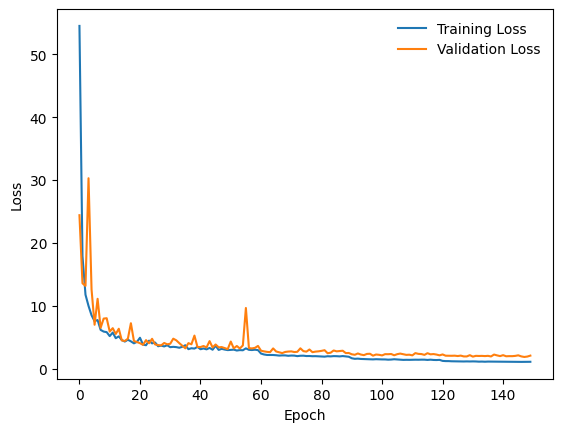

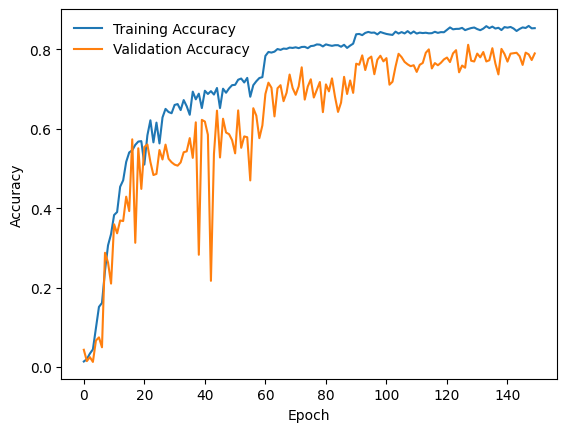

In [18]:
# Plot the training and validation loss
plt.plot(epoch_train_loss, label='Training Loss')
plt.plot(epoch_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

# Plot the training and validation accuracy
plt.plot(epoch_train_acc, label='Training Accuracy')
plt.plot(epoch_val_acc, label='Validation Accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Text(0.5, 0.98, 'Validation Images and Masks')

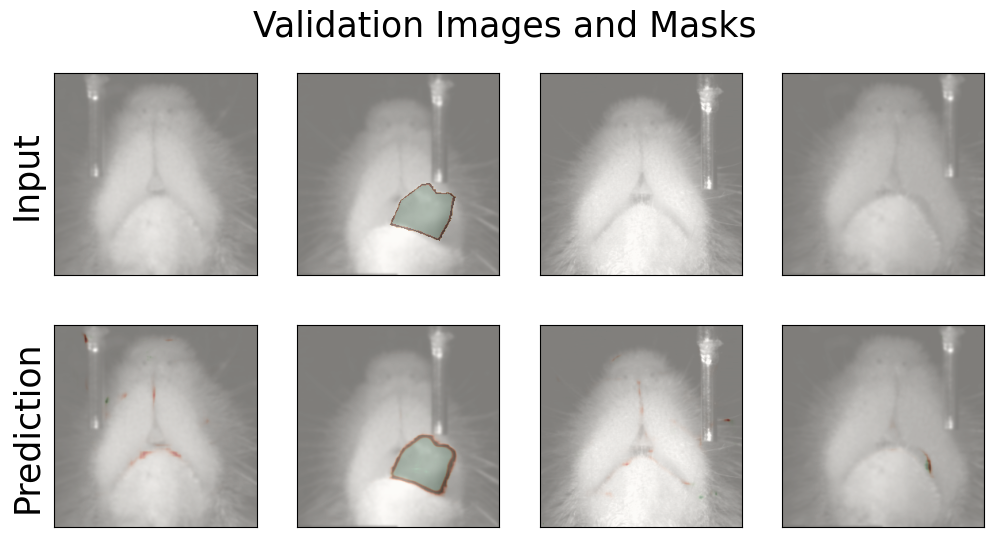

In [19]:
# Get a batch of validation data
batch_data = next(iter(val_loader))
inputs, masks, mask_edges = batch_data['image'], batch_data['mask'], batch_data['mask_edges']
mask_pred, mask_edges_pred, _ = predict(net, inputs, sigmoid=True)
# Plot the images in the batch, along with the corresponding labels
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
for idx in range(len(inputs)):
    ax[0, idx].imshow(inputs[idx].cpu().numpy().squeeze(), cmap='gray')
    ax[0, idx].imshow(masks[idx].cpu().numpy().squeeze(), cmap='Greens', alpha=.3)
    ax[0, idx].imshow(mask_edges[idx].cpu().numpy().squeeze(), cmap='Reds', alpha=.3)
    ax[0, idx].set_yticks([])
    ax[0, idx].set_xticks([])
    ax[1, idx].imshow(inputs[idx].cpu().numpy().squeeze(), cmap='gray')
    ax[1, idx].imshow(mask_pred[idx].squeeze(), cmap='Greens', alpha=.3)
    ax[1, idx].imshow(mask_edges_pred[idx].squeeze(), cmap='Reds', alpha=.3)
    ax[1, idx].set_yticks([])
    ax[1, idx].set_xticks([])
    if idx == 0:
        ax[0, idx].set_ylabel('Input', fontsize=25)
        ax[1, idx].set_ylabel('Prediction', fontsize=25)
    
fig.suptitle('Validation Images and Masks', fontsize=25) 

## Test on out-of-sample data

In [ ]:
# load network weights
#net.load_state_dict(torch.load('model_weights/FMnet_weights_alldat_wdistloss.pt'))

In [ ]:
video_path = '/home/asyeda/oconnorlab_drive/projectData/ConLick/data/RD053/Video/RD053_220217/RD053_Num2_20220217_165434.avi'#'/home/asyeda/oconnorlab_drive/projectData/ConLick/data/RD053/Video/RD053_220216/RD053_Num8_20220216_172008.avi'
selected_idx = 50
img_size = (256, 256)
start_idx = 0

In [ ]:
frame_batch = get_batch_imgs(video_path, selected_idx, batch_size=2, img_size=img_size)
pred_masks, pred_edges, pred_dist = predict(net, torch.tensor(frame_batch))

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 8))
ax[0].imshow(frame_batch[0].squeeze(), cmap='gray')
ax[1].imshow(pred_masks[0].squeeze())
ax[2].imshow(pred_edges[0].squeeze(), cmap='Reds', alpha=1)
plt.show()

#### Video

In [ ]:
num_frames = 500

# Create an animation of video and model predictions
fig, ax = plt.subplots(1, 3, figsize=(10, 5), dpi=100)

batch_imgs = get_batch_imgs(video_path, start_idx, batch_size=1, img_size=img_size)
pred_masks, pred_edges, pred_dist = predict(net, torch.tensor(batch_imgs))
# Plot the first frame
frame_plot = ax[0].imshow(batch_imgs[0].squeeze(), cmap='gray')
ax[0].axis("off")
ax[0].set_title("Frame: " + str(start_idx))
mask_plot = ax[1].imshow(pred_masks[0].squeeze(), cmap='Greens', alpha=1)
ax[1].axis("off")
ax[1].set_title("Predicted mask: " + str(start_idx))
mask_edge_plot = ax[2].imshow(pred_edges[0].squeeze(), cmap='Reds', alpha=1)
ax[2].axis("off")
ax[2].set_title("Predicted edges: " + str(start_idx))

def animate(i):
    batch_imgs = get_batch_imgs(video_path, start_idx+i, batch_size=1, img_size=img_size)
    pred_masks, pred_edges, pred_dist = predict(net, torch.tensor(batch_imgs))
    frame_plot.set_data(batch_imgs[0].squeeze())
    ax[0].set_title("Frame: " + str(start_idx+i))
    mask_plot.set_data(pred_masks[0].squeeze())
    ax[1].set_title("Predicted mask: " + str(start_idx+i))
    mask_edge_plot.set_data(pred_edges[0].squeeze())
    ax[2].set_title("Predicted edges: " + str(start_idx+i))
    return (frame_plot, mask_plot, mask_edge_plot)

anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=50)
HTML(anim.to_html5_video())

## Compute test error

In [ ]:
test_imgs, test_masks, test_mask_distance_to_boundary = load_data('/home/asyeda/Hopkins/Jupyter_notebooks/segmentation_pytorch/datasets/oconnorlab_test_dataset.mat',
                                    image_field_name='imgs', mask_field_name='masks', rotate=False)
# Bounding box for the frames [x1, x2, y1, y2]
test_bbox = [0, test_imgs.shape[2], 0, test_imgs.shape[1]]
test_dataset = TongueMaskDataset(test_imgs, test_masks, test_mask_distance_to_boundary, bbox=test_bbox, img_size=(256, 256), train=False)

In [ ]:
num_frames = test_dataset.__len__() - 4
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
iterator = iter(test_loader)

# Create an animation of video and model predictions
fig, ax = plt.subplots(1, 3, figsize=(10, 5), dpi=100)
start_idx = 0

batch_data = next(iterator)
imgs, masks, edges = batch_data['image'], batch_data['mask'], batch_data['mask_edges']
pred_masks, pred_edges, _ = predict(net, imgs)
# Plot the first frame
frame_plot = ax[0].imshow(imgs[0].squeeze(), cmap='gray')
ax[0].axis("off")
ax[0].set_title("Frame: " + str(start_idx))
mask_plot = ax[1].imshow(pred_masks[0].squeeze(), cmap='Greens', alpha=1)
ax[1].axis("off")
ax[1].set_title("Predicted mask: " + str(start_idx))
mask_edge_plot = ax[2].imshow(pred_edges[0].squeeze(), cmap='Reds', alpha=.4)
ax[2].axis("off")
ax[2].set_title("Predicted edges: " + str(start_idx))

def animate(i):
    batch_data = next(iterator)
    imgs, masks, edges = batch_data['image'], batch_data['mask'], batch_data['mask_edges']
    pred_masks, pred_edges, _ = predict(net, imgs)
    frame_plot.set_data(imgs[0].squeeze())
    ax[0].set_title("Frame: " + str(i))
    mask_plot.set_data(pred_masks[0].squeeze())
    ax[1].set_title("Predicted mask: " + str(i))
    mask_edge_plot.set_data(pred_edges[0].squeeze())
    ax[2].set_title("Predicted edges: " + str(i))
    return (frame_plot, mask_plot, mask_edge_plot)

anim = animation.FuncAnimation(fig, animate, frames=num_frames-1, interval=100)
HTML(anim.to_html5_video())

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4)

# Plot test images and masks
batch_data = next(iter(test_loader))
inputs, masks, mask_edges = batch_data['image'], batch_data['mask'], batch_data['mask_edges']
pred_masks, pred_edges, _ = predict(net, inputs, sigmoid=True, threshold=0.5)
# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 8))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(inputs[idx].numpy().squeeze(), cmap='gray')
    plt.imshow(masks[idx].numpy().squeeze(), cmap='Greens', alpha=.3)
    plt.imshow(mask_edges[idx].cpu().numpy().squeeze(), cmap='Reds', alpha=.2)
    if idx == 0:
        ax.set_ylabel('Input', fontsize=25)
    ax = fig.add_subplot(2, 4, idx+5, xticks=[], yticks=[])
    plt.imshow(inputs[idx].numpy().squeeze(), cmap='gray')
    plt.imshow(pred_masks[idx].squeeze(), cmap='Greens', alpha=.3)
    plt.imshow(pred_edges[idx].squeeze(), cmap='Reds', alpha=.2)
    if idx == 0:
        ax.set_ylabel('Prediction', fontsize=25)
fig.suptitle('Test Images and Masks', fontsize=25)
plt.show()

In [ ]:
# compute the intersection over union for each mask
iou_masks, iou_mask_edges = [], []
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
for batch_data in test_loader:
    inputs, masks, mask_edges = batch_data['image'], batch_data['mask'], batch_data['mask_edges']
    pred_masks, pred_edges, _ = predict(net, inputs, sigmoid=True, threshold=0.5)
    iou_masks.append(iou(pred_masks, masks.numpy()))
    iou_mask_edges.append(iou(pred_edges, mask_edges.numpy()))
print("Mean IoU for masks: ", np.nanmean(iou_masks))
print("Mean IoU for mask edges: ", np.nanmean(iou_mask_edges))